# Resnet

Architektura oparta schematach z https://arxiv.org/pdf/1512.03385v1.pdf

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, ZeroPadding2D, Dense, BatchNormalization, Add, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# CIFAR
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

print(validation_labels[0])

print("################")

# Przekształcenie etykiet na takie, które będą pasowały do modelu
training_labels = to_categorical(training_labels, 10)
validation_labels = to_categorical(validation_labels, 10)

print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

print(validation_labels[0])

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
[3]
################
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [8]:
def residual_connection(base_model, filters, custom_stride = None):

  model = base_model

  if custom_stride is None:
    strides = (1,1)
  else:
    strides = (custom_stride, custom_stride)

  model = Conv2D(filters, kernel_size=(3,3), strides = strides, padding="same")(model)
  model = Conv2D(filters, kernel_size=(3,3), strides = (1,1), padding="same")(model)

  base_model = Conv2D(filters, kernel_size=(1,1), strides = strides)(base_model)

  model = Add()([model, base_model])

  return model

model_input = Input((32,32,3))

model = Conv2D(32, kernel_size=(7,7), strides = (2, 2))(model_input)
model = MaxPooling2D((3,3), strides=(2,2))(model)

model = residual_connection(model, filters = 16, custom_stride = None)
model = residual_connection(model, filters = 16, custom_stride = None)
model = residual_connection(model, filters = 16, custom_stride = None)
model = residual_connection(model, filters = 32, custom_stride = 2)
model = residual_connection(model, filters = 32, custom_stride = None)
model = residual_connection(model, filters = 64, custom_stride = None)
model = residual_connection(model, filters = 64, custom_stride = None)
# model = residual_connection(model, filters = 256, custom_stride = 2)
# model = residual_connection(model, filters = 256, custom_stride = None)
# model = residual_connection(model, filters = 256, custom_stride = None)
# model = residual_connection(model, filters = 256, custom_stride = None)
# model = residual_connection(model, filters = 256, custom_stride = None)
# model = residual_connection(model, filters = 256, custom_stride = None)
# model = residual_connection(model, filters = 512, custom_stride = 2)
# model = residual_connection(model, filters = 512, custom_stride = None)
# model = residual_connection(model, filters = 512, custom_stride = None)

model = AveragePooling2D(pool_size=(2,2))(model)
model = Flatten()(model)
model = Dense(10, activation='softmax')(model)

model = keras.Model(inputs=model_input, outputs=model, name="resnet")

model.summary()


Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_81 (Conv2D)             (None, 13, 13, 32)   4736        ['input_7[0][0]']                
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 6, 6, 32)    0           ['conv2d_81[0][0]']              
                                                                                                  
 conv2d_82 (Conv2D)             (None, 6, 6, 16)     4624        ['max_pooling2d_5[0][0]']        
                                                                                             

In [9]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model.fit(
    x=training_images,
    y=training_labels,
    batch_size=64,
    epochs=20,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/20
782/782 [==============================] - 66s 82ms/step - loss: 7.8176 - accuracy: 0.3346 - val_loss: 1.8319 - val_accuracy: 0.3998
Epoch 2/20
782/782 [==============================] - 58s 74ms/step - loss: 1.7265 - accuracy: 0.4192 - val_loss: 1.6824 - val_accuracy: 0.4247
Epoch 3/20
782/782 [==============================] - 59s 75ms/step - loss: 1.5660 - accuracy: 0.4618 - val_loss: 1.4790 - val_accuracy: 0.4954
Epoch 4/20
782/782 [==============================] - 60s 76ms/step - loss: 1.4639 - accuracy: 0.4938 - val_loss: 1.5232 - val_accuracy: 0.4728
Epoch 5/20
782/782 [==============================] - 61s 78ms/step - loss: 1.4209 - accuracy: 0.5066 - val_loss: 1.4238 - val_accuracy: 0.5026
Epoch 6/20
782/782 [==============================] - 62s 80ms/step - loss: 1.3700 - accuracy: 0.5240 - val_loss: 1.3254 - val_accuracy: 0.5370
Epoch 7/20
782/782 [==============================] - 59s 76ms/step - loss: 1.3388 - accuracy: 0.5358 - val_loss: 1.3576 - val_accuracy:

In [10]:
# ZAPISANIE MODELU

from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("./model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("./model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


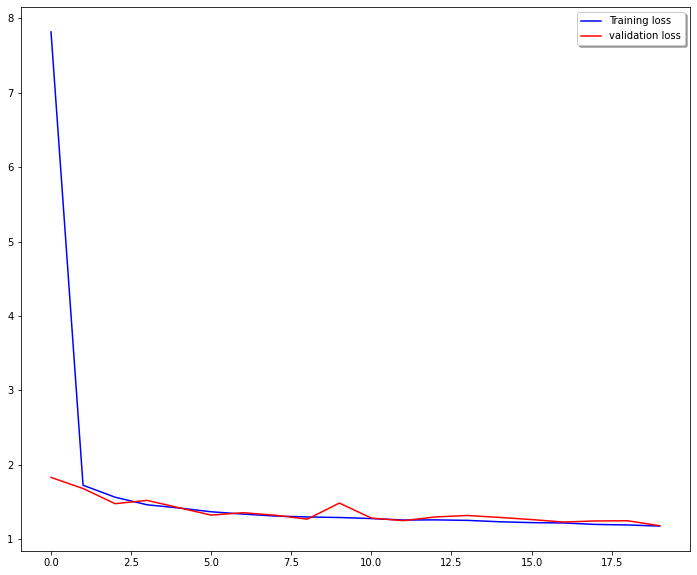

In [11]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(12,10))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)